In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import re

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import nltk # natural language tool kit or spacy
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, LancasterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
# Tokenization - means breaking down a document

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error 
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from collections import Counter
from xgboost import XGBRegressor


In [233]:
!pip install xgboost

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/madhavan.murugesan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [164]:
df = pd.read_csv("zomato.csv")
df.head(10)

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari
5,https://www.zomato.com/bangalore/timepass-dinn...,"37, 5-1, 4th Floor, Bosco Court, Gandhi Bazaar...",Timepass Dinner,Yes,No,3.8/5,286,+91 9980040002\r\n+91 9980063005,Basavanagudi,Casual Dining,"Onion Rings, Pasta, Kadhai Paneer, Salads, Sal...",North Indian,600,"[('Rated 3.0', 'RATED\n Food 3/5\nAmbience 3/...",[],Buffet,Banashankari
6,https://www.zomato.com/bangalore/rosewood-inte...,"19/1, New Timberyard Layout, Beside Satellite ...",Rosewood International Hotel - Bar & Restaurant,No,No,3.6/5,8,+91 9731716688\r\n080 26740366,Mysore Road,Casual Dining,NaN,"North Indian, South Indian, Andhra, Chinese",800,"[('Rated 5.0', 'RATED\n Awesome food ??Great ...",[],Buffet,Banashankari
7,https://www.zomato.com/bangalore/onesta-banash...,"2469, 3rd Floor, 24th Cross, Opposite BDA Comp...",Onesta,Yes,Yes,4.6/5,2556,080 48653961\r\n080 48655715,Banashankari,"Casual Dining, Cafe","Farmhouse Pizza, Chocolate Banana, Virgin Moji...","Pizza, Cafe, Italian",600,"[('Rated 5.0', 'RATED\n I personally really l...",[],Cafes,Banashankari
8,https://www.zomato.com/bangalore/penthouse-caf...,"1, 30th Main Road, 3rd Stage, Banashankari, Ba...",Penthouse Cafe,Yes,No,4.0/5,324,+91 8884135549\r\n+91 9449449316,Banashankari,Cafe,"Pizza, Mocktails, Coffee, Nachos, Salad, Pasta...","Cafe, Italian, Continental",700,"[('Rated 3.0', ""RATED\n I had been to this pl...",[],Cafes,Banashankari
9,https://www.zomato.com/bangalore/smacznego-ban...,"2470, 21 Main Road, 25th Cross, Banashankari, ...",Smacznego,Yes,No,4.2/5,504,+91 9945230807\r\n+91 9743804471,Banashankari,Cafe,"Waffles, Pasta, Coleslaw Sandwich, Choco Waffl...","Cafe, Mexican, Italian, Momos, Beverages",550,"[('Rated 4.0', ""RATED\n Easy to locate\nVFM 3...",[],Cafes,Banashankari


In [165]:
df2 = pd.read_csv("zomato.csv")

In [37]:
df.columns

Index(['name', 'online_order', 'book_table', 'rate', 'votes', 'rest_type',
       'cuisines', 'resturant_type', 'location_city', 'dish_liked_isnull',
       'costfor2', 'Scale_costfor2', 'scale_votes', 'minmax_costfor2',
       'minmax_votes'],
      dtype='object')

In [166]:
# remove the feature's that are not useful for the analysis 
df.drop(columns=['url','address','phone','reviews_list','menu_item'],inplace=True)

In [167]:
## capture the misssing value in dish_liked_isnull feature and drop the column 
df['dish_liked_isnull'] = df['dish_liked'].isnull() * 1 
df['dish_liked_isnull'].value_counts()

dish_liked_isnull
1    28078
0    23639
Name: count, dtype: int64

In [168]:
df.drop('dish_liked',axis=1,inplace = True)

In [169]:
#change data type of "rate" column 
def clean_rate(val):
    if(val=='NEW' or val=='-'):
        return np.nan
    else:
        return float(str(val).split('/')[0])
    
df['rate']=df['rate'].apply(clean_rate)

In [170]:
pd.crosstab(df['dish_liked_isnull'], df['rate'])

rate,1.8,2.0,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,...,4.0,4.1,4.2,4.3,4.4,4.5,4.6,4.7,4.8,4.9
dish_liked_isnull,,,,,,,,,,,,,,,,,,,,,
0,5,11,24,26,45,58,57,149,192,341,...,2940,2850,2146,1691,1143,648,300,167,66,55
1,0,0,0,0,6,12,44,111,115,259,...,243,98,38,2,4,8,0,0,0,0


In [171]:
#REMOVE ',' Present in the column For example 1,200 is converted in to 1200
df['costfor2'] = df['approx_cost(for two people)'].replace({',': ''}, regex=True)

# convert costfor2 into float value - astype cannot be used 
pd.to_numeric(df['costfor2'],errors='coerce')
df['costfor2']=pd.to_numeric(df['costfor2'],errors='coerce')

#remove redundant columns - approx_cost(for two people) 
df.drop(columns=['approx_cost(for two people)'],inplace=True)

#fill missing values in costfor2 feature with median value imputation
df['costfor2'].fillna(df['costfor2'].median(),inplace=True)

In [172]:
#fill missing values in rating feature with mode value imputation
df['rate'].fillna(df['rate'].mean(),inplace=True)

In [173]:
#Rename listed_in(type) and listed_in(city) with appropriate name 

df.rename(columns={'listed_in(city)':'location_city','listed_in(type)' : 'resturant_type' },inplace=True)


In [174]:
#Encoding online_order features - Nominal Encoding 
online_dict = {'Yes':1, 'No':0}
df['online_order'] = df2['online_order'].map(online_dict)
#df['online_order'].value_counts()

#Encoding book_table features - Nominal Encoding 
book_dict = {'Yes':1, 'No':0}
df['book_table'] = df2['book_table'].map(book_dict)
#df['book_table'].value_counts()

#Encoding resturant_type features - Nominal Encoding 
resturant_dict = {'Delivery':1, 'Dine-out':2, 'Buffet':2, 'Cafes':3, 'Desserts':3,'Drinks & nightlife':4,'Pubs and bars':4}
df['resturant_type'] = df2['listed_in(type)'].map(resturant_dict)

In [177]:
#Drop location column since we already have location_city.This feature is redundant. 

df.drop(columns=['location'],inplace=True)

In [176]:
df.head(2)

,name,online_order,book_table,rate,votes,location,rest_type,cuisines,resturant_type,location_city,dish_liked_isnull,costfor2
0,Jalsa,1,1,4.1,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",2,Banashankari,0,800.0
1,Spice Elephant,1,0,4.1,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",2,Banashankari,0,800.0


In [175]:
(df.isnull().sum()/len(df))*100

name                 0.000000
online_order         0.000000
book_table           0.000000
rate                 0.000000
votes                0.000000
location             0.040606
rest_type            0.438927
cuisines             0.087012
resturant_type       0.000000
location_city        0.000000
dish_liked_isnull    0.000000
costfor2             0.000000
dtype: float64

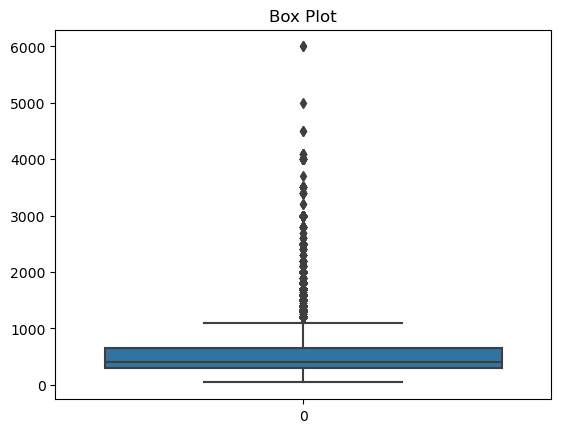

In [26]:
##Verifying the outlier present in the data
sns.boxplot(data=df['costfor2'])
plt.title('Box Plot')
plt.show()

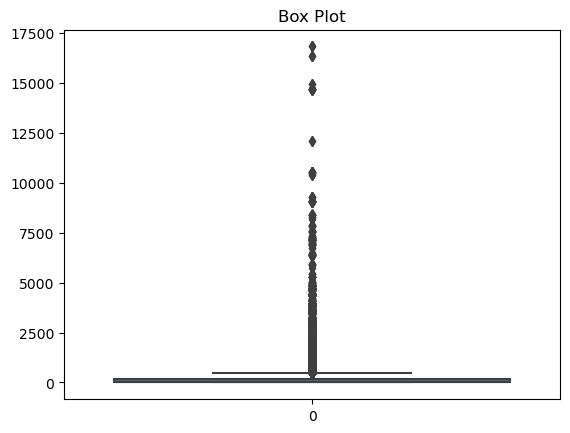

In [28]:
##Verifying the outlier present in the data
sns.boxplot(data=df['votes'])
plt.title('Box Plot')
plt.show()

In [178]:
##Feature Scaling - scaling costfor2 feature to create a new feature Scale_costfor2
scaler = StandardScaler()
scale_costfor2= df['costfor2'].values.reshape(-1, 1)
scaler.fit(scale_costfor2)
scaled_costfor2 = scaler.transform(scale_costfor2)
df['Scale_costfor2'] = scaled_costfor2

##Feature Scaling - votes rate feature to create a new feature Scale_votes
scaler = StandardScaler()
scale_votes= df['votes'].values.reshape(-1, 1)
scaler.fit(scale_votes)
scale_votes = scaler.transform(scale_votes)
df['scale_votes'] = scale_votes

In [179]:
#MinMax Scaler 
scaler = MinMaxScaler()
scale_costfor2= df['costfor2'].values.reshape(-1, 1)
#scaler.fit(scale_costfor2)
#scaled_costfor2 = scaler.transform(scale_costfor2)
scaled_costfor2 = scaler.fit_transform(scale_costfor2)
df['minmax_costfor2'] = scaled_costfor2

#MinMax Scaler 
scaler = MinMaxScaler()
scale_votes= df['votes'].values.reshape(-1, 1)
#scaler.fit(scale_costfor2)
#scaled_costfor2 = scaler.transform(scale_costfor2)
scale_votes = scaler.fit_transform(scale_votes)
df['minmax_votes'] = scale_votes

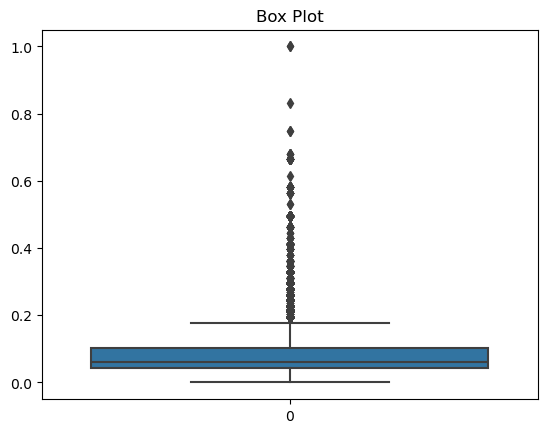

In [180]:
sns.boxplot(data=df['minmax_costfor2'])
plt.title('Box Plot')
plt.show()

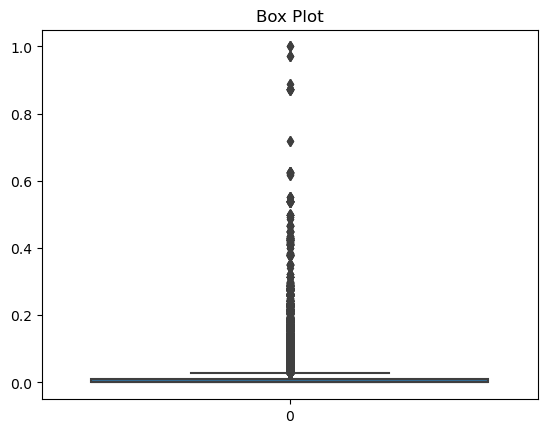

In [29]:
sns.boxplot(data=df['minmax_votes'])
plt.title('Box Plot')
plt.show()

In [181]:
#####Identify outlier using percentile method

print(np.percentile(df['costfor2'], 0))
print(np.percentile(df['costfor2'], 10))
print(np.percentile(df['costfor2'], 20))
print(np.percentile(df['costfor2'], 30))
print(np.percentile(df['costfor2'], 40))
print(np.percentile(df['costfor2'], 50))
print(np.percentile(df['costfor2'], 60))
print(np.percentile(df['costfor2'], 70))
print(np.percentile(df['costfor2'], 80))
##################################################
print(np.percentile(df['costfor2'], 81))
print(np.percentile(df['costfor2'], 82))
print(np.percentile(df['costfor2'], 83))
print(np.percentile(df['costfor2'], 84))
print(np.percentile(df['costfor2'], 85))
print(np.percentile(df['costfor2'], 86))
print(np.percentile(df['costfor2'], 87))
print(np.percentile(df['costfor2'], 88))
print(np.percentile(df['costfor2'], 89))
print(np.percentile(df['costfor2'], 90))
#####################################################

print(np.percentile(df['costfor2'], 91))
print(np.percentile(df['costfor2'], 92))
print(np.percentile(df['costfor2'], 93))
print(np.percentile(df['costfor2'], 94))
print(np.percentile(df['costfor2'], 95))
print(np.percentile(df['costfor2'], 96))
print(np.percentile(df['costfor2'], 97))
print(np.percentile(df['costfor2'], 98))
print(np.percentile(df['costfor2'], 99))
print(np.percentile(df['costfor2'], 100))

40.0
200.0
250.0
300.0
400.0
400.0
500.0
600.0
750.0
800.0
800.0
800.0
800.0
850.0
900.0
1000.0
1000.0
1000.0
1100.0
1200.0
1200.0
1300.0
1400.0
1500.0
1500.0
1600.0
1900.0
2200.0
6000.0


In [22]:

print(np.percentile(df['votes'], 0))
print(np.percentile(df['votes'], 10))
print(np.percentile(df['votes'], 20))
print(np.percentile(df['votes'], 30))
print(np.percentile(df['votes'], 40))
print(np.percentile(df['votes'], 50))
print(np.percentile(df['votes'], 60))
print(np.percentile(df['votes'], 70))
print(np.percentile(df['votes'], 80))
print(np.percentile(df['votes'], 81))
print(np.percentile(df['votes'], 82))
print(np.percentile(df['votes'], 83))
print(np.percentile(df['votes'], 84))
print(np.percentile(df['votes'], 85))
print(np.percentile(df['votes'], 86))
print(np.percentile(df['votes'], 87))
print(np.percentile(df['votes'], 88))
print(np.percentile(df['votes'], 89))
print(np.percentile(df['votes'], 90))
print(np.percentile(df['votes'], 91))
print(np.percentile(df['votes'], 92))
print(np.percentile(df['votes'], 93))
print(np.percentile(df['votes'], 94))
print(np.percentile(df['votes'], 95))
print(np.percentile(df['votes'], 96))
print(np.percentile(df['votes'], 97))
print(np.percentile(df['votes'], 98))
print(np.percentile(df['votes'], 99))
print(np.percentile(df['votes'], 100))

0.0
0.0
4.0
10.0
22.0
41.0
74.0
141.0
281.0
302.0
331.0
358.0
391.43999999999505
428.0
464.0
506.0
557.0
618.0
703.0
783.0
873.0
1013.0
1161.0
1372.0
1708.7200000000012
2040.0
2634.6800000000003
3847.8399999999965
16832.0


In [31]:
print(np.percentile(df['minmax_votes'], 0))
print(np.percentile(df['minmax_votes'], 10))
print(np.percentile(df['minmax_votes'], 20))
print(np.percentile(df['minmax_votes'], 30))
print(np.percentile(df['minmax_votes'], 40))
print(np.percentile(df['minmax_votes'], 50))
print(np.percentile(df['minmax_votes'], 60))
print(np.percentile(df['minmax_votes'], 70))
print(np.percentile(df['minmax_votes'], 80))
print(np.percentile(df['minmax_votes'], 85))
print(np.percentile(df['minmax_votes'], 90))
print(np.percentile(df['minmax_votes'], 95))
print(np.percentile(df['minmax_votes'], 100))

0.0
0.0
0.0002376425855513308
0.000594106463878327
0.0013070342205323193
0.0024358365019011407
0.00439638783269962
0.008376901140684411
0.016694391634980987
0.025427756653992394
0.04176568441064639
0.08151140684410646
1.0


In [30]:
print(np.percentile(df['minmax_costfor2'], 0))
print(np.percentile(df['minmax_costfor2'], 10))
print(np.percentile(df['minmax_costfor2'], 20))
print(np.percentile(df['minmax_costfor2'], 30))
print(np.percentile(df['minmax_costfor2'], 40))
print(np.percentile(df['minmax_costfor2'], 50))
print(np.percentile(df['minmax_costfor2'], 60))
print(np.percentile(df['minmax_costfor2'], 70))
print(np.percentile(df['minmax_costfor2'], 80))
print(np.percentile(df['minmax_costfor2'], 85))
print(np.percentile(df['minmax_costfor2'], 90))
print(np.percentile(df['minmax_costfor2'], 95))
print(np.percentile(df['minmax_costfor2'], 100))

0.0
0.026845637583892617
0.03523489932885906
0.0436241610738255
0.06040268456375839
0.06040268456375839
0.07718120805369126
0.09395973154362415
0.11912751677852347
0.13590604026845637
0.17785234899328858
0.2449664429530201
0.9999999999999999


In [23]:
##verifying the data present for costfor2 with value as 6000.0
df[df['costfor2'] == 6000.0]

,name,online_order,book_table,rate,votes,rest_type,cuisines,resturant_type,location_city,dish_liked_isnull,costfor2,Scale_costfor2,scale_votes,minmax_costfor2,minmax_votes
19139,Le Cirque Signature - The Leela Palace,0,1,4.3,126,Fine Dining,"French, Italian",2,Indiranagar,0,6000.0,12.445412,-0.196182,1.0,0.007486
45618,Le Cirque Signature - The Leela Palace,0,1,4.3,128,Fine Dining,"French, Italian",2,Old Airport Road,0,6000.0,12.445412,-0.193694,1.0,0.007605


In [25]:
##verifying the data present for votes with value as 16832.0

df[df['votes']== 16832.0]

,name,online_order,book_table,rate,votes,rest_type,cuisines,resturant_type,location_city,dish_liked_isnull,costfor2,Scale_costfor2,scale_votes,minmax_costfor2,minmax_votes
49170,Byg Brewski Brewing Company,1,1,4.9,16832,Microbrewery,"Continental, North Indian, Italian, South Indi...",1,Sarjapur Road,0,1600.0,2.389637,20.586791,0.261745,1.0
49627,Byg Brewski Brewing Company,1,1,4.9,16832,Microbrewery,"Continental, North Indian, Italian, South Indi...",2,Sarjapur Road,0,1600.0,2.389637,20.586791,0.261745,1.0
50059,Byg Brewski Brewing Company,1,1,4.9,16832,Microbrewery,"Continental, North Indian, Italian, South Indi...",4,Sarjapur Road,0,1600.0,2.389637,20.586791,0.261745,1.0


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


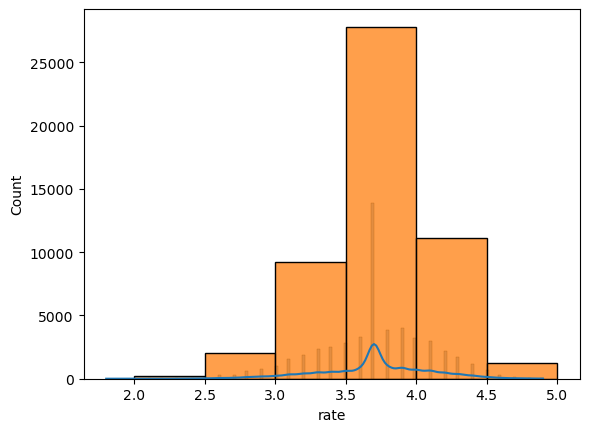

In [33]:
sns.histplot(df['rate'], kde=True)
#Distribution Analysis 
sns.histplot(df['rate'], bins=[2,2.5,3,3.5,4,4.5,5])
plt.show()

In [54]:
subdf = df[['online_order', 'book_table','dish_liked_isnull','Scale_costfor2', 'scale_votes', 'minmax_costfor2','minmax_votes','resturant_type']]

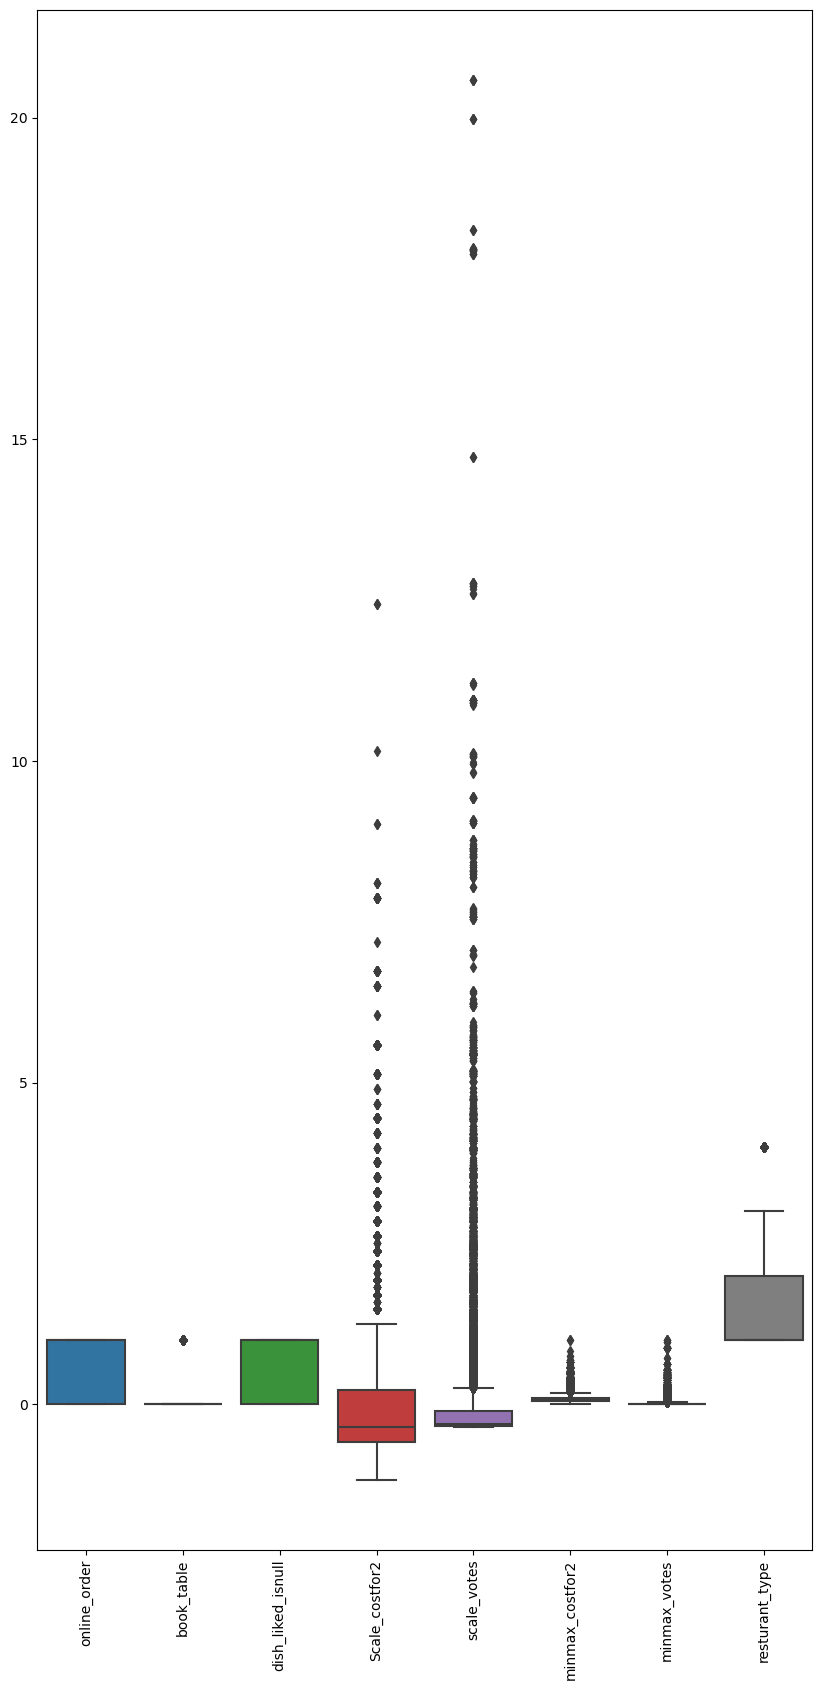

In [55]:
plt.figure(figsize=(10,20))
sns.boxplot(subdf)
plt.xticks(rotation=90)
plt.show()

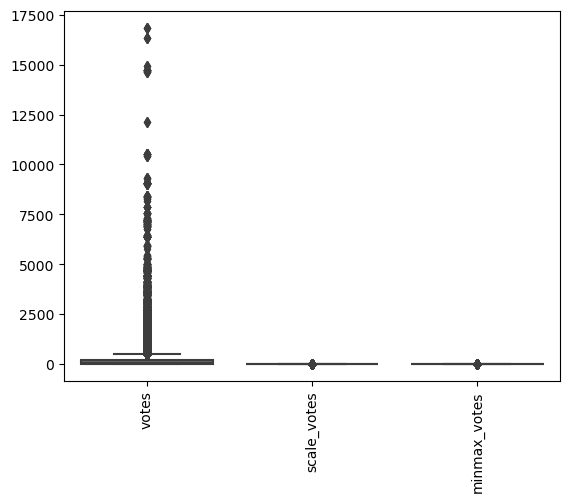

In [44]:
sns.boxplot(df[['votes', 'scale_votes', 'minmax_votes']])
plt.xticks(rotation=90)
plt.show()

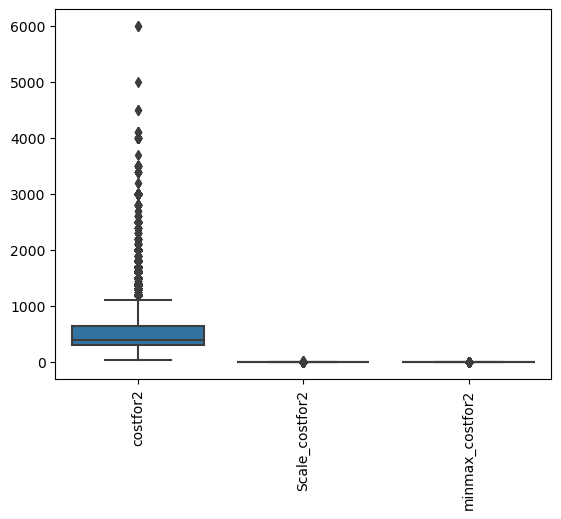

In [45]:
sns.boxplot(df[['costfor2', 'Scale_costfor2', 'minmax_costfor2']])
plt.xticks(rotation=90)
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

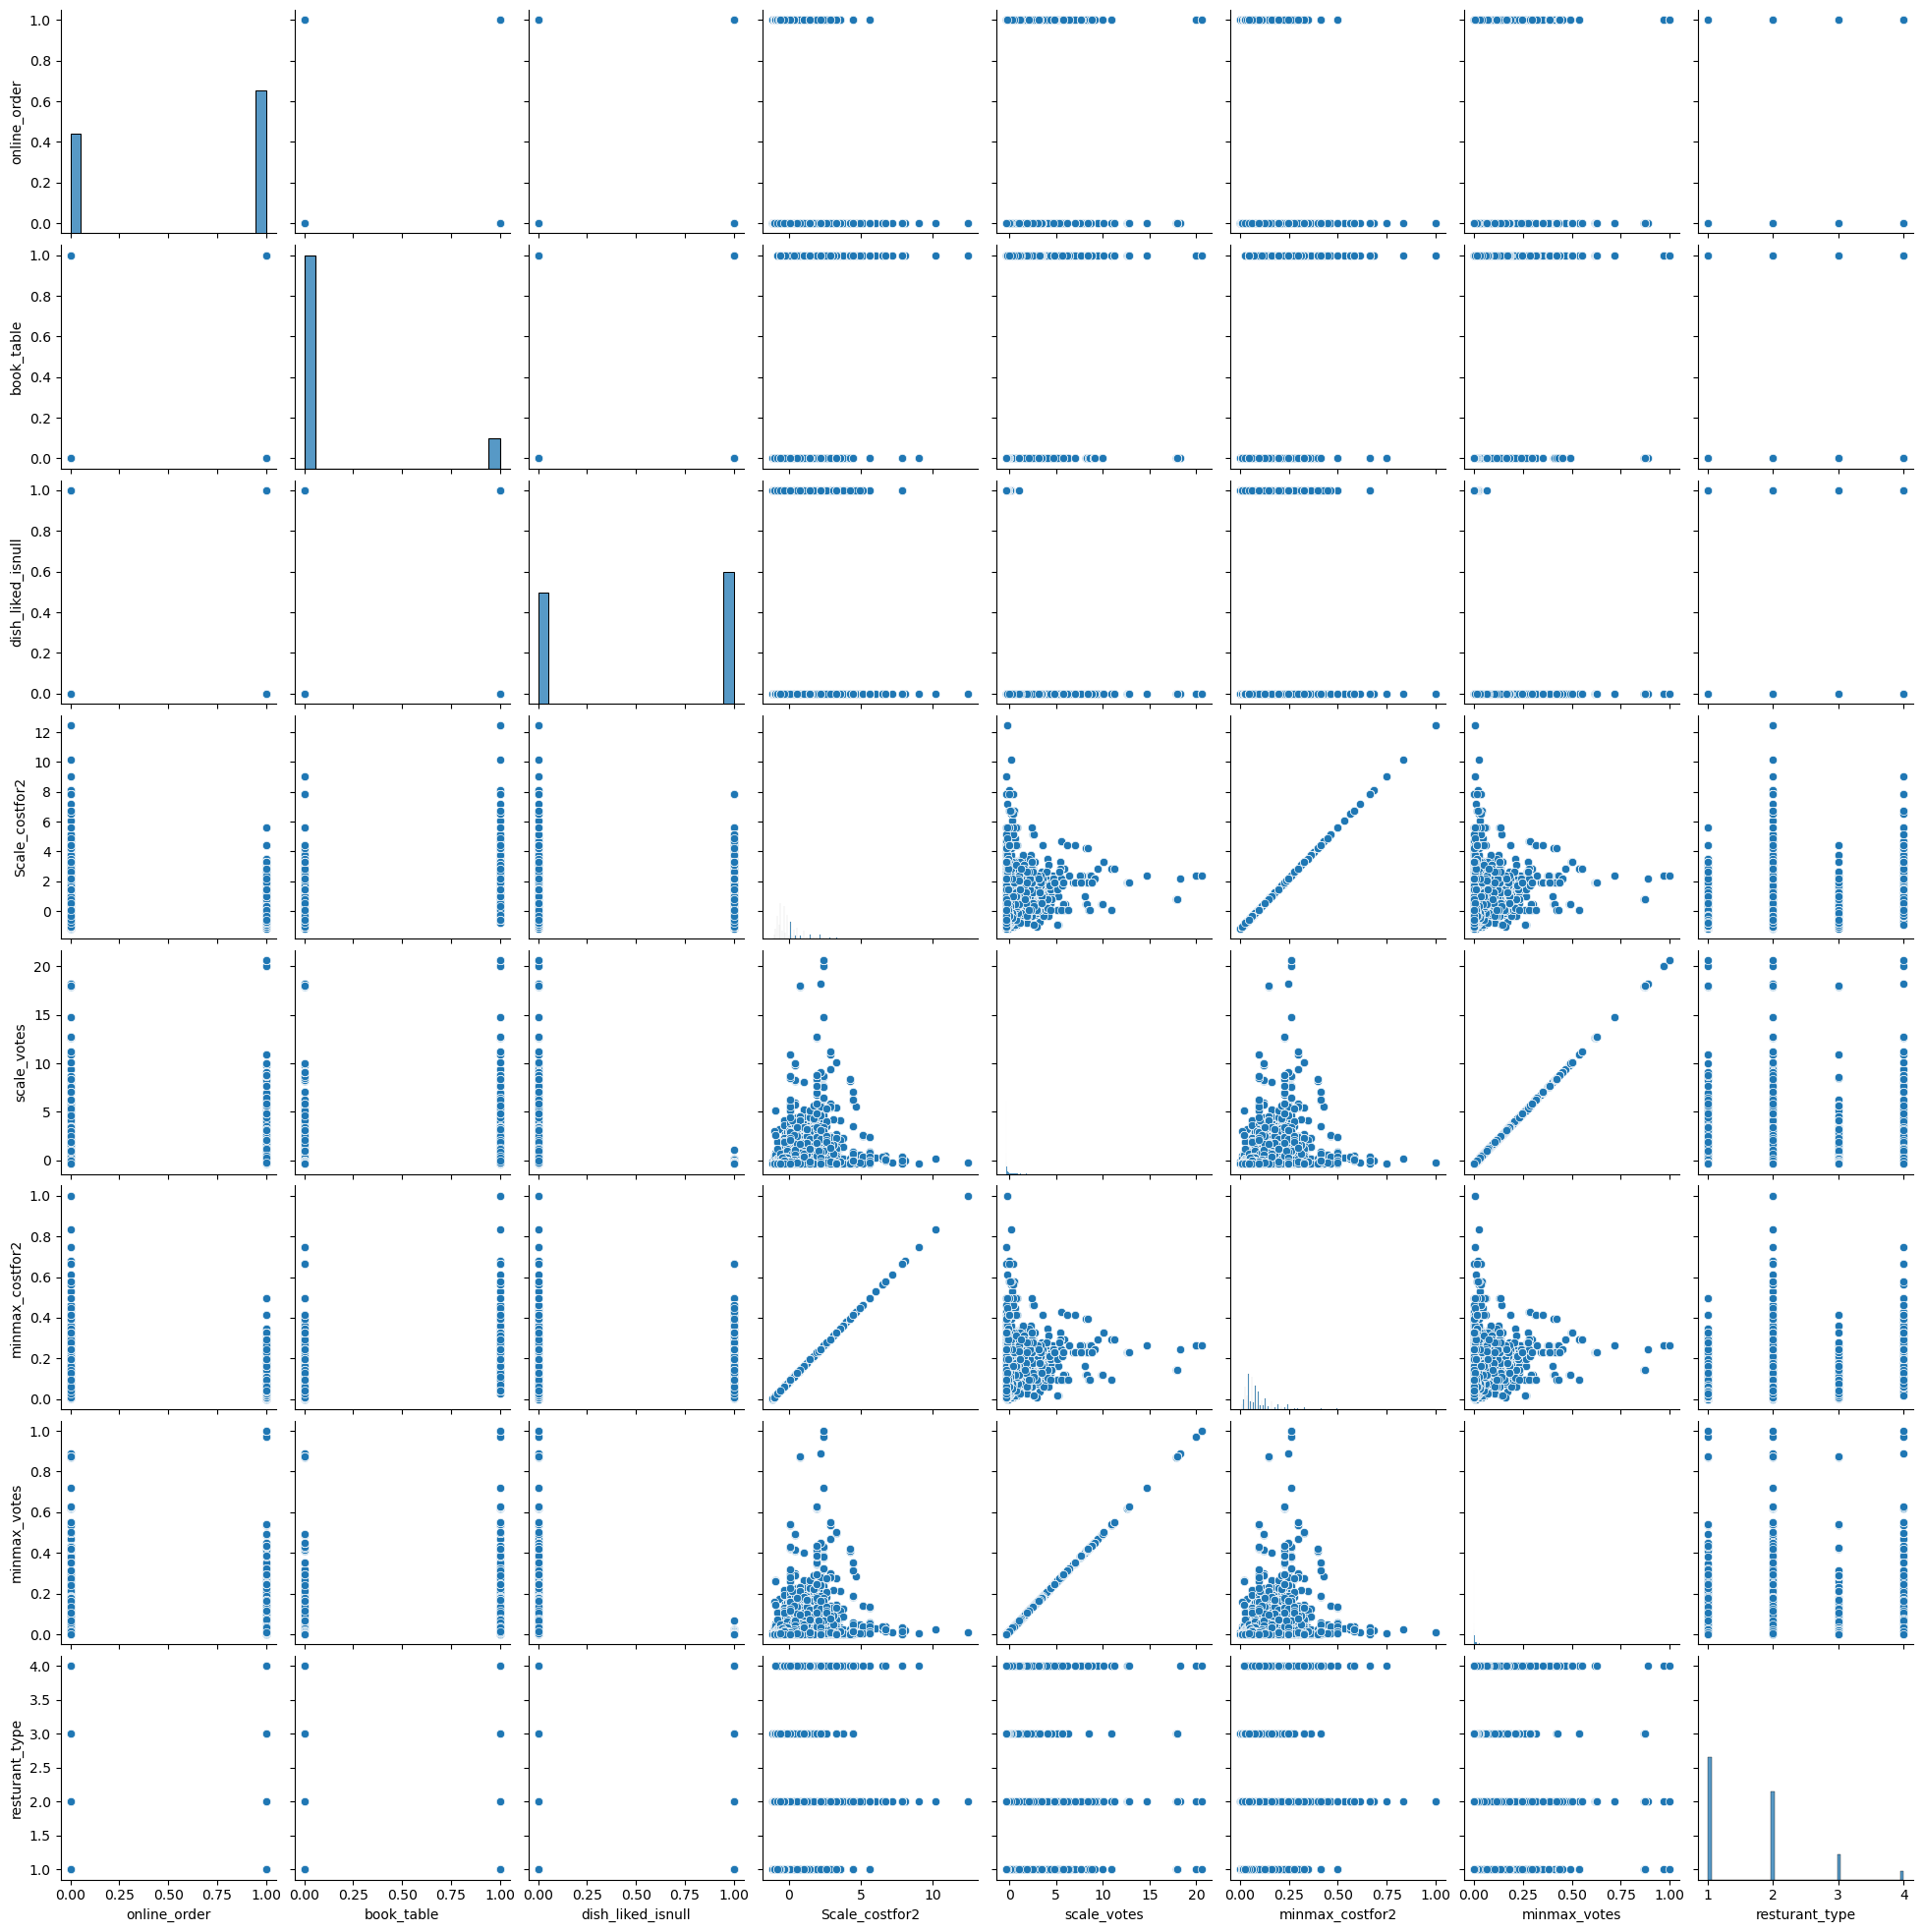

In [56]:

sns.pairplot(subdf)
plt.show()

In [59]:
#Analyse the correlation between the numeric column 
c = subdf.corr()
c

,online_order,book_table,dish_liked_isnull,Scale_costfor2,scale_votes,minmax_costfor2,minmax_votes,resturant_type
online_order,1.000000,0.001035,-0.204501,-0.079908,0.034714,-0.079908,0.034714,-0.268495
book_table,0.001035,1.000000,-0.376933,0.618449,0.405428,0.618449,0.405428,0.199005
dish_liked_isnull,-0.204501,-0.376933,1.000000,-0.414870,-0.361555,-0.414870,-0.361555,-0.114276
Scale_costfor2,-0.079908,0.618449,-0.414870,1.000000,0.380992,1.000000,0.380992,0.270907
scale_votes,0.034714,0.405428,-0.361555,0.380992,1.000000,0.380992,1.000000,0.146215
minmax_costfor2,-0.079908,0.618449,-0.414870,1.000000,0.380992,1.000000,0.380992,0.270907
minmax_votes,0.034714,0.405428,-0.361555,0.380992,1.000000,0.380992,1.000000,0.146215
resturant_type,-0.268495,0.199005,-0.114276,0.270907,0.146215,0.270907,0.146215,1.000000


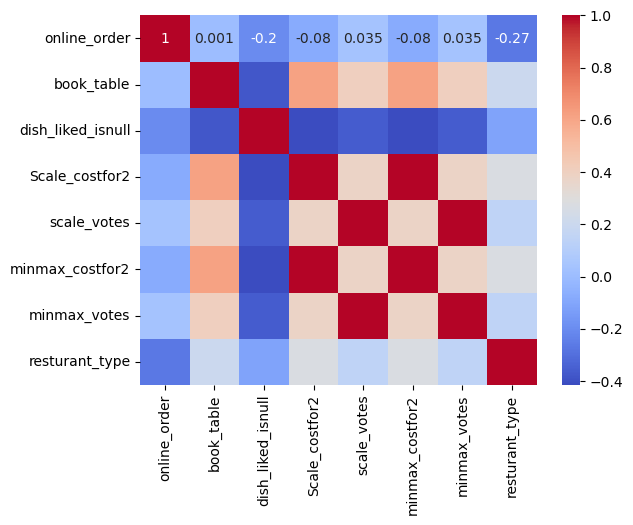

In [60]:
sns.heatmap(c, annot=True, cmap='coolwarm')
plt.show()

In [182]:
### Analysing the values in rest_type column 
df['rest_type'].unique()


## unique values in rest_type features can be grouped into the following feature values 
## Buffet, Cafe, Delivery, Desserts, Dine-out, Drinks and nightlife, pubs and bars
## Which will create redundant features since it is already available under resturant_type. 
## Hence the feature rest_type is dropped. 

array(['Casual Dining', 'Cafe, Casual Dining', 'Quick Bites',
       'Casual Dining, Cafe', 'Cafe', 'Quick Bites, Cafe',
       'Cafe, Quick Bites', 'Delivery', 'Mess', 'Dessert Parlor',
       'Bakery, Dessert Parlor', 'Pub', 'Bakery', 'Takeaway, Delivery',
       'Fine Dining', 'Beverage Shop', 'Sweet Shop', 'Bar',
       'Beverage Shop, Quick Bites', 'Confectionery',
       'Quick Bites, Beverage Shop', 'Dessert Parlor, Sweet Shop',
       'Bakery, Quick Bites', 'Sweet Shop, Quick Bites', 'Kiosk',
       'Food Truck', 'Quick Bites, Dessert Parlor',
       'Beverage Shop, Dessert Parlor', 'Takeaway', 'Pub, Casual Dining',
       'Casual Dining, Bar', 'Dessert Parlor, Beverage Shop',
       'Quick Bites, Bakery', 'Dessert Parlor, Quick Bites',
       'Microbrewery, Casual Dining', 'Lounge', 'Bar, Casual Dining',
       'Food Court', 'Cafe, Bakery', nan, 'Dhaba',
       'Quick Bites, Sweet Shop', 'Microbrewery',
       'Food Court, Quick Bites', 'Pub, Bar', 'Casual Dining, Pub',
      

In [183]:
df.drop(columns = ['rest_type'], inplace = True)

In [189]:
df.head(3)

,name,online_order,book_table,rate,votes,cuisines,resturant_type,location_city,dish_liked_isnull,costfor2,...,lavelle_road,malleshwaram,marathahalli,mg_road,new_bel_road,old_airport_road,rajajinagar,residency_road,sarjapur_road,whitefield
0,Jalsa,1,1,4.1,775,"North Indian, Mughlai, Chinese",2,banashankari,0,800.0,...,0,0,0,0,0,0,0,0,0,0
1,Spice Elephant,1,0,4.1,787,"Chinese, North Indian, Thai",2,banashankari,0,800.0,...,0,0,0,0,0,0,0,0,0,0
2,San Churro Cafe,1,0,3.8,918,"Cafe, Mexican, Italian",2,banashankari,0,800.0,...,0,0,0,0,0,0,0,0,0,0


In [190]:
df['location_city'].value_counts()

location_city
btm                      3279
koramangala_7th_block    2938
koramangala_5th_block    2836
koramangala_4th_block    2779
koramangala_6th_block    2623
jayanagar                2371
jp_nagar                 2096
indiranagar              1860
church_street            1827
mg_road                  1811
brigade_road             1769
lavelle_road             1744
hsr                      1741
marathahalli             1659
residency_road           1620
whitefield               1620
bannerghatta_road        1617
brookefield              1518
old_airport_road         1425
kammanahalli             1329
kalyan_nagar             1309
basavanagudi             1266
sarjapur_road            1261
electronic_city          1229
bellandur                1227
frazer_town              1185
malleshwaram             1096
rajajinagar              1079
banashankari              863
new_bel_road              740
Name: count, dtype: int64

In [186]:
df['location_city'] = df['location_city'].str.lower()
df['location_city'] = df['location_city'].str.replace(' ', '_')


In [188]:
# Perform encoding with prefix and drop_first=False
encode_location = pd.get_dummies(df['location_city'].str.get_dummies(sep=', '))

# # Concatenate the original DataFrame with the encoded features
df = pd.concat([df, encode_location], axis=1)


In [75]:
# Perform encoding with prefix and drop_first=False
encode_location = pd.get_dummies(df['location_city'].str.get_dummies(sep=', '))

# # Concatenate the original DataFrame with the encoded features
df = pd.concat([df, encode_location], axis=1)


In [77]:
df.drop(columns = 'location_city', inplace = True)

In [141]:
df.head(3)

,name,online_order,book_table,rate,votes,cuisines,resturant_type,dish_liked_isnull,costfor2,Scale_costfor2,...,lavelle_road,malleshwaram,marathahalli,mg_road,new_bel_road,old_airport_road,rajajinagar,residency_road,sarjapur_road,whitefield
0,Jalsa,1,1,4.1,775,"indian_cuisine_cuisine,indian_cuisine,asian_cu...",2,0,800.0,0.561314,...,0,0,0,0,0,0,0,0,0,0
1,Spice Elephant,1,0,4.1,787,"asian_cuisine,indian_cuisine_cuisine,asian_cui...",2,0,800.0,0.561314,...,0,0,0,0,0,0,0,0,0,0
2,San Churro Cafe,1,0,3.8,918,"beverages,western_cuisine,western_cuisine",2,0,800.0,0.561314,...,0,0,0,0,0,0,0,0,0,0


In [191]:
df['cuisines'] = df['cuisines'].str.lower()
df['cuisines'] = df['cuisines'].str.replace(' ', '_')
df['cuisines'] = df['cuisines'].str.replace(',_', ' , ')
#df['cuisines'] = df['cuisines'].str.replace('\'', '')


In [192]:
df['cuisines'].value_counts()

cuisines
north_indian                                      2913
north_indian , chinese                            2385
south_indian                                      1828
biryani                                            918
bakery , desserts                                  911
                                                  ... 
north_indian , chinese , south_indian , juices       1
north_indian , chinese , kebab , mughlai             1
chinese , vietnamese , thai , malaysian              1
arabian , lebanese , chinese , rolls                 1
north_indian , chinese , arabian , momos             1
Name: count, Length: 2723, dtype: int64

In [193]:
#list_cusine  = [ each_item.split(',') for each_item in cusines ]

list_cusine = [each_item.split(',') for each_item in cusines if isinstance(each_item, str)]

cusine_type = [cusine_type for each_list in list_cusine for cusine_type in each_list]

cusine_list = [cusine for cusine in cusine_type]
cusine_counter = Counter(cusine_type)
cusine_counter


Counter({'indian_cuisine': 43972,
         'asian_cuisine': 20357,
         'fast_street_food': 17882,
         'western_cuisine': 14980,
         'beverages': 11787,
         'desserts_snacks': 10247,
         'other_cuisine': 5601,
         'mid_east_cuisine': 1481,
         'fast_fast_street_food': 512})

In [194]:
cusine_dict = {
    'north_indian':'indian_cuisine',
    'indian': 'indian_cuisine',
    'malwani': 'indian_cuisine',
    'south_indian': 'indian_cuisine',
    'biryani': 'indian_cuisine',
    'andhra': 'indian_cuisine',
    'mughlai': 'indian_cuisine',
    'kerala': 'indian_cuisine',
    'mangalorean': 'indian_cuisine',
    'bengali': 'indian_cuisine',
    'hyderabadi': 'indian_cuisine',
    'chettinad': 'indian_cuisine',
    'rajasthani': 'indian_cuisine', 
    'modern_indian': 'indian_cuisine', 
    'maharashtrian': 'indian_cuisine', 
    'oriya': 'indian_cuisine',
    'goan': 'indian_cuisine',
    'bihari': 'indian_cuisine',
    'konkan': 'indian_cuisine',
    'north_eastern': 'indian_cuisine',
    'lucknowi': 'indian_cuisine', 
    'kashmiri': 'indian_cuisine',   
    'awadhi': 'indian_cuisine',
    'parsi': 'indian_cuisine',
    'assamese': 'indian_cuisine',
    'naga': 'indian_cuisine',
    'sindhi':'indian_cuisine',
    'tamil': 'indian_cuisine',
    ##Asian Cuisine
    'chinese': 'asian_cuisine',
    'asian': 'asian_cuisine',
    'thai': 'asian_cuisine',
    'japanese': 'asian_cuisine',
    'tibetan': 'asian_cuisine',        
    'vietnamese': 'asian_cuisine',
    'korean': 'asian_cuisine',
    'malaysian': 'asian_cuisine',
    'indonesian': 'asian_cuisine',
    'nepalese': 'asian_cuisine',
    'burmese': 'asian_cuisine',  
    'singaporean': 'asian_cuisine',
    'sushi': 'asian_cuisine',
    'sri_lankan': 'asian_cuisine',
    'mongolian': 'asian_cuisine',  
    'pan_asian': 'asian_cuisine',
    ###fast_street_food####
    'fast_food': 'fast_street_food',
    'street_food': 'fast_street_food',
    'burger': 'fast_street_food',
    'rolls': 'fast_street_food',
    'momos': 'fast_street_food',
    'finger_food': 'fast_street_food',
    'kebab': 'fast_street_food', 
    'steak': 'fast_street_food',
    ### western_cuisine ###
    'continental': 'western_cuisine',
    'italian': 'western_cuisine',
    'pizza': 'western_cuisine',
    'american': 'western_cuisine',
    'european': 'western_cuisine',
    'mediterranean': 'western_cuisine',
    'mexican': 'western_cuisine', 
    'gujarati': 'western_cuisine',
    'turkish': 'western_cuisine',  
    'french': 'western_cuisine',     
    'tex-mex': 'western_cuisine', 
    'spanish': 'western_cuisine',
    'greek': 'western_cuisine',  
    'south_american': 'western_cuisine',
    'portuguese': 'western_cuisine', 
    'british': 'western_cuisine', 
    'russian': 'western_cuisine',
    'jewish': 'western_cuisine',
    'german': 'western_cuisine',
    'australian': 'western_cuisine',
    'belgian': 'western_cuisine',
    ### desserts_snacks ### 
    'desserts': 'desserts_snacks',
    'bakery': 'desserts_snacks',
    'ice_cream': 'desserts_snacks',
    'mithai': 'desserts_snacks',
    ### beverages #####
    'cafe': 'beverages',
    'beverages': 'beverages',    
    'juices': 'beverages',  
    'coffee': 'beverages',      
    'tea': 'beverages',  
    'drinks_only': 'beverages',
    'bubble_tea': 'beverages',    
    'bar_food': 'beverages',
     ### other_cuisine #### 
    'seafood': 'other_cuisine',
    'salad': 'other_cuisine', 
    'healthy_food': 'other_cuisine',
    'sandwich': 'other_cuisine',
    'bbq': 'other_cuisine',
    'charcoal_chicken': 'other_cuisine', 
    'african': 'other_cuisine',
    'bohri': 'other_cuisine',
    'cantonese': 'other_cuisine',
    'vegan': 'other_cuisine',
    #### mid_east_cuisine #### 
    'arabian': 'mid_east_cuisine',
    'lebanese': 'mid_east_cuisine', 
    'middle_eastern': 'mid_east_cuisine',
    'afghan': 'mid_east_cuisine',
    'iranian': 'mid_east_cuisine',         
    'afghani': 'mid_east_cuisine',
    #### fast_street_food ###
    'wraps': 'fast_street_food',      
    'grill': 'fast_street_food',
    'roast_chicken': 'fast_street_food', 
    'hot_dogs': 'fast_street_food',     
    'raw_meats': 'fast_street_food',     
    'paan': 'fast_street_food'
}

df['cuisines'] = df['cuisines'].replace(cusine_dict, regex=True)

In [195]:
cuisine_dict_correction = { 'asian_cuisine_cuisine':'asian_cuisine',
    'bubble_beverages':'beverages',
    'fast_fast_street_food':'fast_street_food',
    'indian_cuisine_cuisine':'indian_cuisine',
    'mid_east_cuisinei':'mid_east_cuisine',
    'miasian_cuisine':'asian_cuisine',
    'south_western_cuisine':'western_cuisine'
}

df['cuisines'] = df['cuisines'].replace(cuisine_dict_correction, regex=True)

In [196]:
df['cuisines'].value_counts()

cuisines
indian_cuisine                                                                         6462
indian_cuisine , indian_cuisine                                                        2965
indian_cuisine , asian_cuisine                                                         2885
desserts_snacks , desserts_snacks                                                      1894
indian_cuisine , indian_cuisine , asian_cuisine                                        1844
                                                                                       ... 
fast_street_food , fast_street_food , desserts_snacks                                     1
asian_cuisine , desserts_snacks , desserts_snacks                                         1
fast_street_food , indian_cuisine , indian_cuisine , other_cuisine , indian_cuisine       1
fast_street_food , desserts_snacks , western_cuisine , desserts_snacks                    1
western_cuisine , western_cuisine , other_cuisine , western_cuisine , a

In [152]:
encode_cusine = pd.get_dummies(df['cuisines'].str.get_dummies(sep=', '))

# # Concatenate the original DataFrame with the encoded features
df = pd.concat([df, encode_cusine], axis=1)

df

,name,online_order,book_table,rate,votes,cuisines,resturant_type,dish_liked_isnull,costfor2,Scale_costfor2,...,"western_cuisine,western_cuisine,western_cuisine,indian_cuisine,asian_cuisine,fast_street_food,asian_cuisine,asian_cuisine","western_cuisine,western_cuisine,western_cuisine,indian_cuisine,fast_street_food","western_cuisine,western_cuisine,western_cuisine,indian_cuisine,fast_street_food,asian_cuisine,fast_street_food","western_cuisine,western_cuisine,western_cuisine,indian_cuisine,western_cuisine","western_cuisine,western_cuisine,western_cuisine,indian_cuisine,western_cuisine,fast_street_food","western_cuisine,western_cuisine,western_cuisine,other_cuisine","western_cuisine,western_cuisine,western_cuisine,other_cuisine,other_cuisine","western_cuisine,western_cuisine,western_cuisine,western_cuisine","western_cuisine,western_cuisine,western_cuisine,western_cuisine,indian_cuisine,asian_cuisine","western_cuisine,western_cuisine,western_cuisine,western_cuisine,other_cuisine"
0,Jalsa,1,1,4.100000,775,"indian_cuisine,indian_cuisine,asian_cuisine",2,0,800.0,0.561314,...,0,0,0,0,0,0,0,0,0,0
1,Spice Elephant,1,0,4.100000,787,"asian_cuisine,indian_cuisine,asian_cuisine",2,0,800.0,0.561314,...,0,0,0,0,0,0,0,0,0,0
2,San Churro Cafe,1,0,3.800000,918,"beverages,western_cuisine,western_cuisine",2,0,800.0,0.561314,...,0,0,0,0,0,0,0,0,0,0
3,Addhuri Udupi Bhojana,0,0,3.700000,88,"indian_cuisine,indian_cuisine",2,0,300.0,-0.581388,...,0,0,0,0,0,0,0,0,0,0
4,Grand Village,0,0,3.800000,166,"indian_cuisine,indian_cuisine",2,0,600.0,0.104233,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51712,Best Brews - Four Points by Sheraton Bengaluru...,0,0,3.600000,27,western_cuisine,4,1,1500.0,2.161097,...,0,0,0,0,0,0,0,0,0,0
51713,Vinod Bar And Restaurant,0,0,3.700449,0,fast_street_food,4,1,600.0,0.104233,...,0,0,0,0,0,0,0,0,0,0
51714,Plunge - Sheraton Grand Bengaluru Whitefield H...,0,0,3.700449,0,fast_street_food,4,1,2000.0,3.303798,...,0,0,0,0,0,0,0,0,0,0
51715,Chime - Sheraton Grand Bengaluru Whitefield Ho...,0,1,4.300000,236,fast_street_food,4,0,2500.0,4.446500,...,0,0,0,0,0,0,0,0,0,0


In [199]:
encode_cusine = pd.get_dummies(df['cuisines'].str.get_dummies(sep=' , '))


In [201]:
df = pd.concat([df, encode_cusine], axis=1)

In [202]:
df.columns

Index(['name', 'online_order', 'book_table', 'rate', 'votes', 'cuisines',
       'resturant_type', 'location_city', 'dish_liked_isnull', 'costfor2',
       'Scale_costfor2', 'scale_votes', 'minmax_costfor2', 'minmax_votes',
       'banashankari', 'bannerghatta_road', 'basavanagudi', 'bellandur',
       'brigade_road', 'brookefield', 'btm', 'church_street',
       'electronic_city', 'frazer_town', 'hsr', 'indiranagar', 'jayanagar',
       'jp_nagar', 'kalyan_nagar', 'kammanahalli', 'koramangala_4th_block',
       'koramangala_5th_block', 'koramangala_6th_block',
       'koramangala_7th_block', 'lavelle_road', 'malleshwaram', 'marathahalli',
       'mg_road', 'new_bel_road', 'old_airport_road', 'rajajinagar',
       'residency_road', 'sarjapur_road', 'whitefield', 'asian_cuisine',
       'beverages', 'desserts_snacks', 'fast_street_food', 'indian_cuisine',
       'mid_east_cuisine', 'other_cuisine', 'western_cuisine'],
      dtype='object')

In [204]:
df.drop(columns = 'cuisines', inplace = True)

In [206]:
df.drop(columns = 'location_city', inplace = True)

In [216]:
df['Koramangala'] = df['koramangala_4th_block'] | df['koramangala_5th_block'] | df['koramangala_6th_block']| df['koramangala_7th_block']


In [218]:
df.drop(columns = ['koramangala_4th_block','koramangala_5th_block','koramangala_6th_block','koramangala_7th_block'], inplace = True)

In [249]:
df['other_locations'] = df['electronic_city'] | df['kammanahalli'] | df['bannerghatta_road']| df['banashankari']| df['brookefield']  

In [250]:
df.drop(columns = ['electronic_city','kammanahalli','bannerghatta_road','banashankari','brookefield'], inplace = True)

In [251]:
df.columns

Index(['name', 'online_order', 'book_table', 'rate', 'votes', 'resturant_type',
       'dish_liked_isnull', 'costfor2', 'Scale_costfor2', 'scale_votes',
       'minmax_costfor2', 'minmax_votes', 'basavanagudi', 'bellandur',
       'brigade_road', 'btm', 'church_street', 'frazer_town', 'hsr',
       'indiranagar', 'jayanagar', 'jp_nagar', 'kalyan_nagar', 'lavelle_road',
       'malleshwaram', 'marathahalli', 'mg_road', 'new_bel_road',
       'old_airport_road', 'rajajinagar', 'residency_road', 'sarjapur_road',
       'whitefield', 'asian_cuisine', 'beverages', 'desserts_snacks',
       'fast_street_food', 'indian_cuisine', 'mid_east_cuisine',
       'other_cuisine', 'western_cuisine', 'Koramangala', 'other_locations'],
      dtype='object')

In [252]:
learn_features = df[['online_order', 'book_table', 'rate', 'votes', 'resturant_type',
       'dish_liked_isnull', 'costfor2', 'Scale_costfor2', 'scale_votes',
       'minmax_costfor2', 'minmax_votes', 'basavanagudi', 'bellandur',
       'brigade_road', 'btm', 'church_street', 'frazer_town', 'hsr',
       'indiranagar', 'jayanagar', 'jp_nagar', 'kalyan_nagar', 'lavelle_road',
       'malleshwaram', 'marathahalli', 'mg_road', 'new_bel_road',
       'old_airport_road', 'rajajinagar', 'residency_road', 'sarjapur_road',
       'whitefield', 'asian_cuisine', 'beverages', 'desserts_snacks',
       'fast_street_food', 'indian_cuisine', 'mid_east_cuisine',
       'other_cuisine', 'western_cuisine', 'Koramangala', 'other_locations']]

In [253]:
# extracting features and target 

x = learn_features.drop('rate', axis = 1) #features
y = learn_features['rate']#target

In [254]:
learn_features.shape

(51717, 42)

In [255]:
x.shape, y.shape

((51717, 41), (51717,))

In [256]:
x_train, x_eval, y_train, y_eval = train_test_split(x,y,test_size = 0.2, random_state = 0 )

In [257]:
x_train.shape, x_eval.shape, y_train.shape, y_eval.shape

((41373, 41), (10344, 41), (41373,), (10344,))

In [258]:
#### Linear Regression ####
lr = LinearRegression()
lr.fit(x_train,y_train)
train_pred = lr.predict(x_train)
train_error = mean_squared_error(y_train, train_pred)
lr_pred = lr.predict(x_eval)
error = mean_squared_error(y_eval, lr_pred)
print(train_error, error)

0.09794793498787377 0.10165320221306674


In [259]:
r2_score(y_eval, lr_pred)

0.3670649233292377

In [265]:
import math
math.sqrt(error)

0.3188309931814452

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

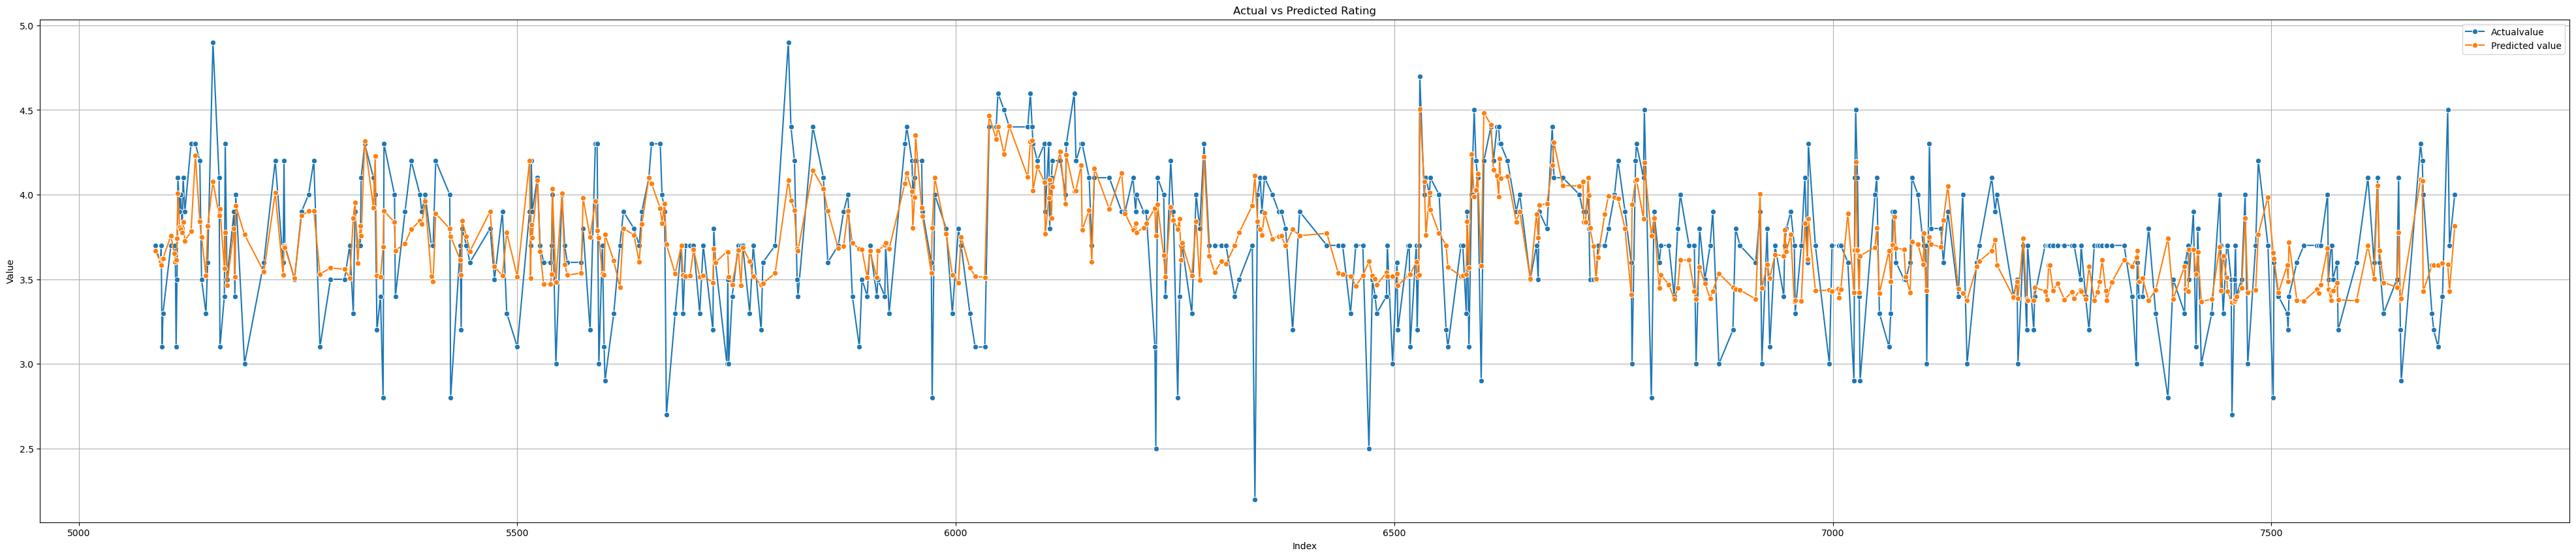

In [232]:
plt.figure(figsize=(50,10))
# Specify the range of index values for plotting
start_index = 1000
end_index = 1500


df_plot = pd.DataFrame({'y_eval':y_eval, 'lr_pred':lr_pred})
df_plot = df_plot.sort_index()

# Extract the data corresponding to the specified range of index values
subset_df = df_plot.iloc[start_index:end_index]


sns.lineplot(x = subset_df.index, y = subset_df['y_eval'], marker = 'o', label = 'Actualvalue')
sns.lineplot(x = subset_df.index, y = subset_df['lr_pred'], marker = 'o', label = 'Predicted value')
plt.title('Actual vs Predicted Rating')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()



In [263]:
rg = Ridge(100)
rg.fit(x_train, y_train)
rg_pred = rg.predict(x_train)
train_error = mean_squared_error(y_train, train_pred)
rg_pred = rg.predict(x_eval)
error_rg = mean_squared_error(y_eval, rg_pred)
print(train_error, error_rg)
r2_score(y_eval, rg_pred)

0.09794793498787377 0.10166825828289013


0.3669711779823075

In [264]:
import math
rmse = math.sqrt(error_rg)
print(rmse)

0.3188546036720971


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

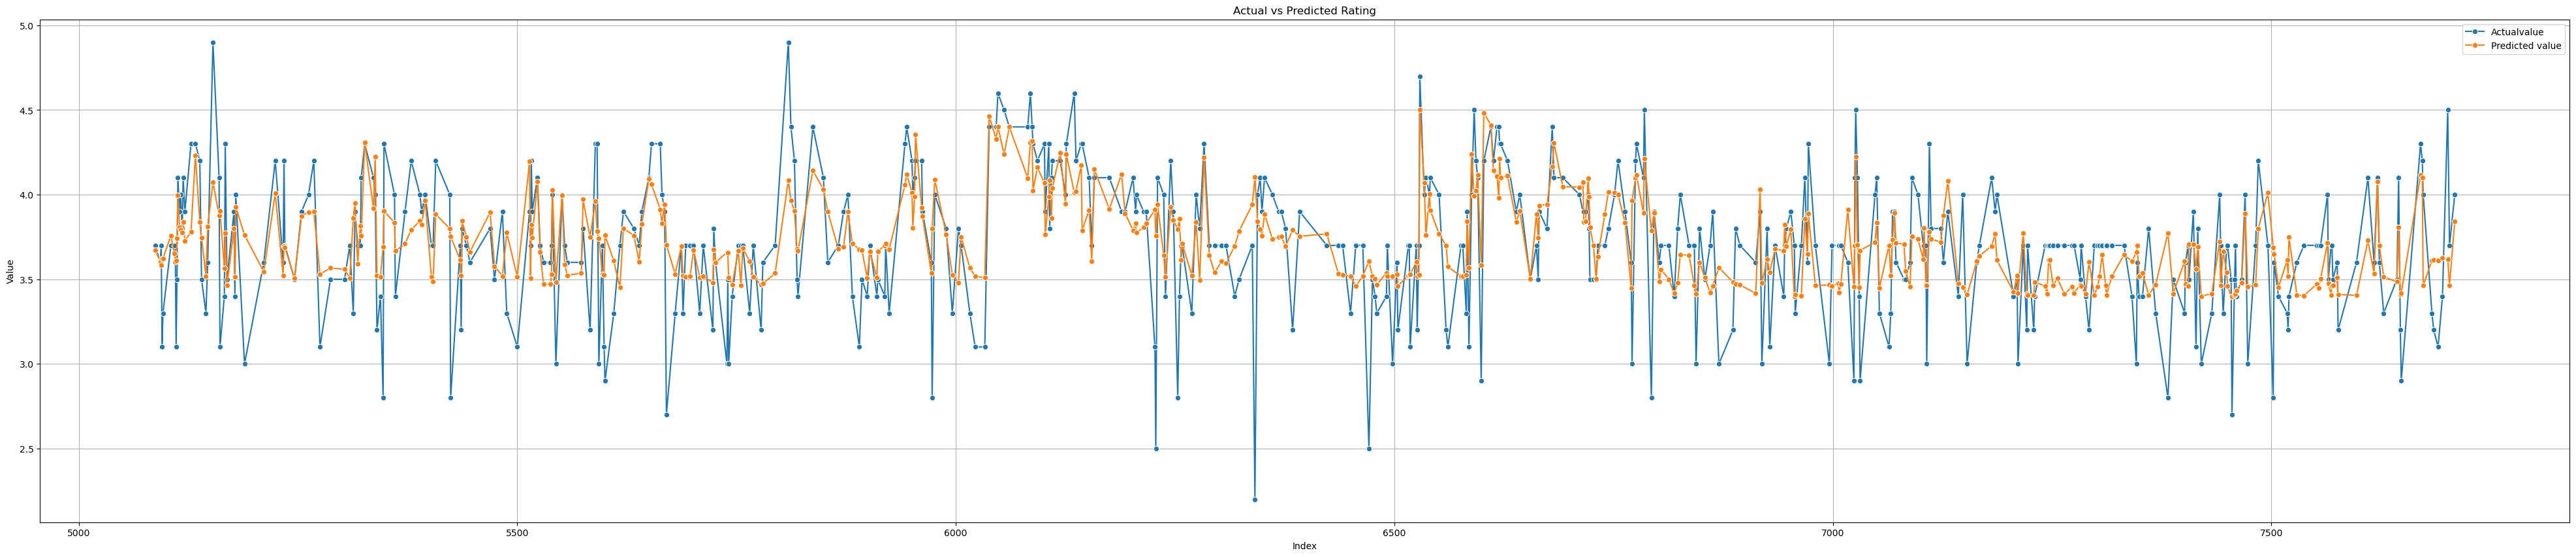

In [269]:
plt.figure(figsize=(50,10))
# Specify the range of index values for plotting
start_index = 1000
end_index = 1500


df_plot = pd.DataFrame({'y_eval':y_eval, 'rg_pred':rg_pred})
df_plot = df_plot.sort_index()

# Extract the data corresponding to the specified range of index values
subset_df = df_plot.iloc[start_index:end_index]


sns.lineplot(x = subset_df.index, y = subset_df['y_eval'], marker = 'o', label = 'Actualvalue')
sns.lineplot(x = subset_df.index, y = subset_df['rg_pred'], marker = 'o', label = 'Predicted value')
plt.title('Actual vs Predicted Rating')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()



In [270]:
rg.coef_

array([-3.44744311e-03,  2.13255721e-01,  1.05519404e-04,  5.04431306e-03,
       -2.24108104e-01,  5.34443014e-05,  1.22141866e-07,  1.31270648e-07,
        8.96716848e-09,  6.26899588e-09,  2.56945012e-02, -3.11029868e-02,
        2.65985073e-02,  1.81305604e-02,  2.87382727e-02,  1.75370248e-02,
       -4.85333599e-03, -1.93174027e-02,  1.31090025e-02, -9.04229200e-03,
        1.71680161e-03,  2.26662303e-02,  1.28999163e-02, -4.82272602e-02,
        1.59520596e-02, -6.55148991e-03, -3.32836422e-02,  1.34520811e-02,
        2.36301991e-02, -5.51024166e-02, -2.20166578e-02, -5.84318115e-02,
        3.82838356e-02,  9.61220136e-02, -4.07811162e-03, -4.58707838e-02,
       -2.17875454e-02,  3.08041936e-02,  1.71110579e-02,  3.94054173e-02,
       -3.00330901e-02])

In [271]:
feat_imp_rg = pd.Series(rg.coef_, index=x_train.columns)

In [272]:
feat_imp_rg.sort_values(ascending=False)

book_table           2.132557e-01
desserts_snacks      9.612201e-02
Koramangala          3.940542e-02
beverages            3.828384e-02
other_cuisine        3.080419e-02
church_street        2.873827e-02
brigade_road         2.659851e-02
basavanagudi         2.569450e-02
residency_road       2.363020e-02
lavelle_road         2.266623e-02
btm                  1.813056e-02
frazer_town          1.753702e-02
western_cuisine      1.711106e-02
mg_road              1.595206e-02
rajajinagar          1.345208e-02
jayanagar            1.310900e-02
malleshwaram         1.289992e-02
resturant_type       5.044313e-03
kalyan_nagar         1.716802e-03
votes                1.055194e-04
costfor2             5.344430e-05
scale_votes          1.312706e-07
Scale_costfor2       1.221419e-07
minmax_costfor2      8.967168e-09
minmax_votes         6.268996e-09
online_order        -3.447443e-03
fast_street_food    -4.078112e-03
hsr                 -4.853336e-03
new_bel_road        -6.551490e-03
jp_nagar      

In [274]:
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.20, early_stopping_rounds=20)
xgb_model.fit(x_train, y_train, eval_metric='mae', eval_set=[(x_train, y_train), (x_eval, y_eval)])
xgb_pred = xgb_model.predict(x_eval)

[0]	validation_0-mae:0.25232	validation_1-mae:0.25677
[1]	validation_0-mae:0.22902	validation_1-mae:0.23343
[2]	validation_0-mae:0.21170	validation_1-mae:0.21623
[3]	validation_0-mae:0.19938	validation_1-mae:0.20395
[4]	validation_0-mae:0.19055	validation_1-mae:0.19502
[5]	validation_0-mae:0.18429	validation_1-mae:0.18886
[6]	validation_0-mae:0.18016	validation_1-mae:0.18483
[7]	validation_0-mae:0.17707	validation_1-mae:0.18177
[8]	validation_0-mae:0.17516	validation_1-mae:0.17976
[9]	validation_0-mae:0.17352	validation_1-mae:0.17825
[10]	validation_0-mae:0.17240	validation_1-mae:0.17738
[11]	validation_0-mae:0.17176	validation_1-mae:0.17696
[12]	validation_0-mae:0.17071	validation_1-mae:0.17607
[13]	validation_0-mae:0.16999	validation_1-mae:0.17545
[14]	validation_0-mae:0.16911	validation_1-mae:0.17471
[15]	validation_0-mae:0.16846	validation_1-mae:0.17401
[16]	validation_0-mae:0.16785	validation_1-mae:0.17363
[17]	validation_0-mae:0.16722	validation_1-mae:0.17315
[18]	validation_0-ma

/opt/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-mae:0.16496	validation_1-mae:0.17159
[23]	validation_0-mae:0.16465	validation_1-mae:0.17137
[24]	validation_0-mae:0.16416	validation_1-mae:0.17099
[25]	validation_0-mae:0.16337	validation_1-mae:0.17042
[26]	validation_0-mae:0.16311	validation_1-mae:0.17038
[27]	validation_0-mae:0.16259	validation_1-mae:0.16983
[28]	validation_0-mae:0.16226	validation_1-mae:0.16972
[29]	validation_0-mae:0.16212	validation_1-mae:0.16977
[30]	validation_0-mae:0.16157	validation_1-mae:0.16945
[31]	validation_0-mae:0.16124	validation_1-mae:0.16915
[32]	validation_0-mae:0.16109	validation_1-mae:0.16903
[33]	validation_0-mae:0.16082	validation_1-mae:0.16887
[34]	validation_0-mae:0.16047	validation_1-mae:0.16860
[35]	validation_0-mae:0.16018	validation_1-mae:0.16837
[36]	validation_0-mae:0.15987	validation_1-mae:0.16835
[37]	validation_0-mae:0.15956	validation_1-mae:0.16818
[38]	validation_0-mae:0.15927	validation_1-mae:0.16801
[39]	validation_0-mae:0.15911	validation_1-mae:0.16791
[40]	valid

In [268]:
error_xg = mean_squared_error(y_eval, xgb_pred)
print(math.sqrt(error_xg))
r2_xg = r2_score(y_eval, xgb_pred)
print(r2_xg)

0.1883521396543066
0.7791083920119357


In [276]:

df_plot = pd.DataFrame({'y_eval':y_eval, 'xgb_pred':xgb_pred})
df_plot = df_plot.sort_index()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

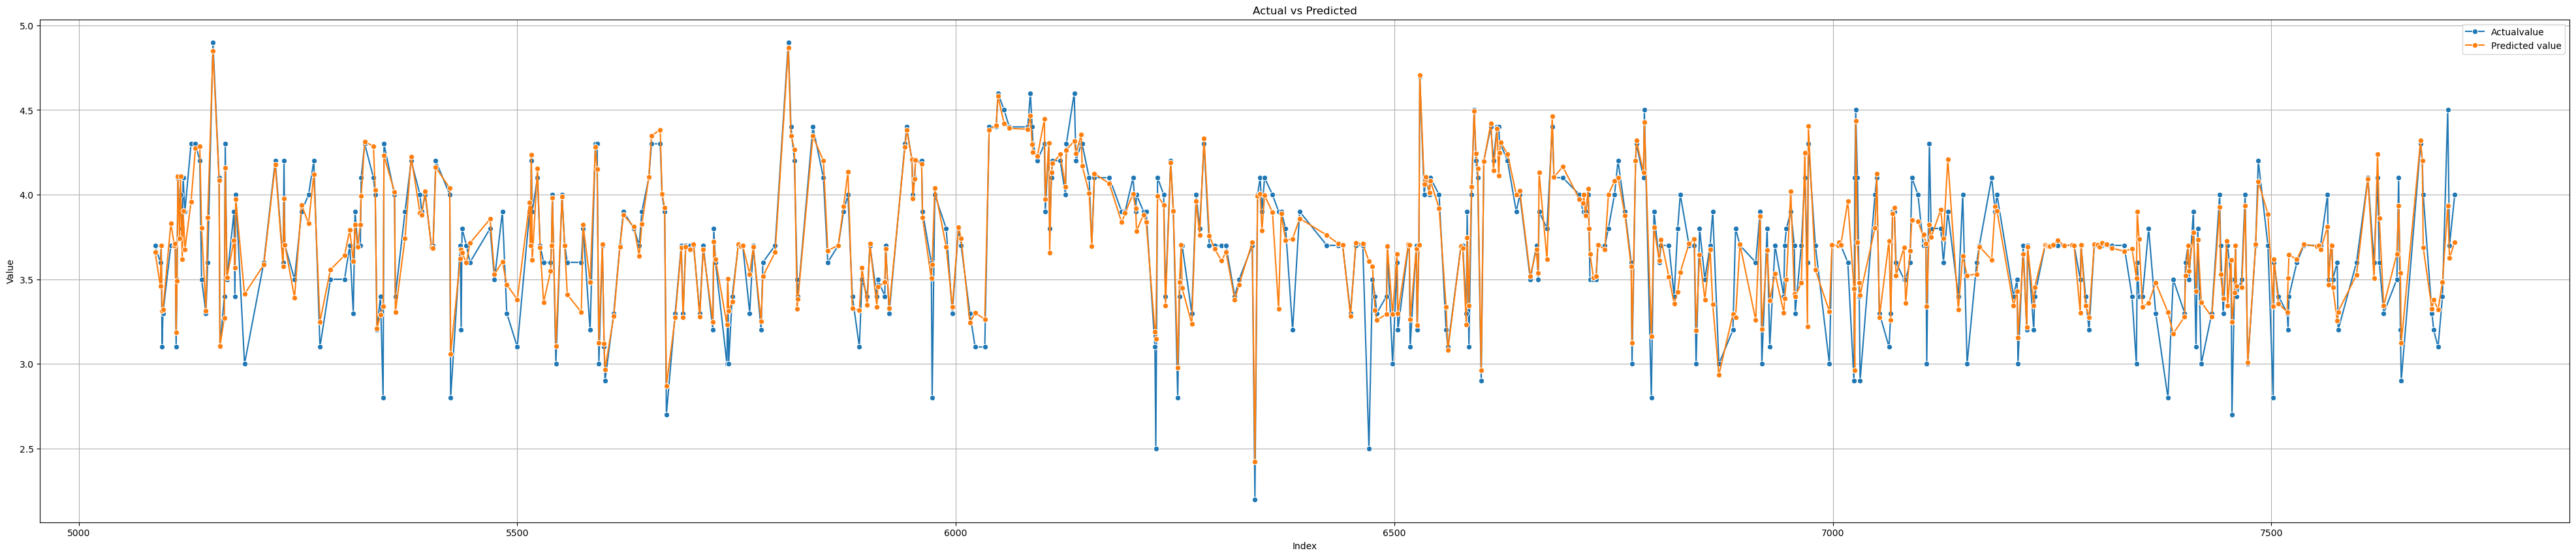

In [277]:
plt.figure(figsize=(50,10))
# Specify the range of index values for plotting
start_index = 1000
end_index = 1500

# Extract the data corresponding to the specified range of index values
subset_df = df_plot.iloc[start_index:end_index]


sns.lineplot(x = subset_df.index, y = subset_df['y_eval'], marker = 'o', label = 'Actualvalue')
sns.lineplot(x = subset_df.index, y = subset_df['xgb_pred'], marker = 'o', label = 'Predicted value')
plt.title('Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()